In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import pandas as pd

导入网络结构

In [2]:
#from __future__ import division
#from math import sqrt

class DoubleConV(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConV, self).__init__()
        self.pad = nn.ReplicationPad2d(1)
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, padding_mode='replicate', bias=False),
            #这里设置了bias = false, 应该相当于后面对bias取成全零矩阵，有待验证？
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, padding_mode='replicate', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, X):
        return self.double_conv(X)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool = nn.Sequential(
            nn.MaxPool2d(2),
            #注：此处stride=None,但是Xin等设置了stride=2
            DoubleConV(in_channels, out_channels)
        )

    def forward(self, X):
        return self.maxpool(X)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            #self.up = nn.Upsample(scale_factor=2, model='bilnear', align_corners='True'),
            #bilinear双线性插值
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)
            # scale_factor输出对输入的倍数，主要改变图片高宽，bilinear双线性插值
            self.conv = DoubleConV(in_channels, out_channels, in_channels//2)
            #self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
            #self.bn = nn.BatchNorm2d(out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            #没有加padding，待验证？
            self.conv = DoubleConV(in_channels, out_channels)
            #转置卷积，另外一种上采样的方式，不过一般都用双线性插值方法

    def forward(self, X1, X2):
        X1 = self.up(X1)
        #X1 = self.conv1(X1)
        #X1 = self.bn(X1)
        #将X1通道数减半
        #print(X2.size(),X1.size())
        if not (X2.size()[2] == X1.size()[2] or X2.size()[3] == X1.size()[3]):
            DetaX = X1.size()[2] - X2.size()[2]
            DetaY = X1.size()[3] - X2.size()[3]
            X2 = F.pad(X2, [DetaX // 2, DetaX - DetaX // 2,
                            DetaY // 2, DetaY - DetaY // 2], mode='replicate')
            #如果X1和X2大小不一样，将X2进行填充，到和X1相同的大小
            print('there is different cat_size, and we let X2 the same as X1 atomatically')
            #输出提示
        X = torch.cat([X2, X1], dim=1)
        #对每个通道的X1,X2整合到一起
        return self.conv(X)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, X):
        return self.conv(X)

In [3]:
class Unet(nn.Module):
    def __init__(self, colordim=1, n_classes=2, drop=0.5, bilinear=True):
        super(Unet, self).__init__()
        self.colordim = colordim
        self.n_classes = n_classes

        self.inp = DoubleConV(colordim, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512,1024//factor)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outp = OutConv(64, n_classes)
        #self.dropout = nn.Dropout(drop)

    def forward(self, X, drop=0.5):
        X1 = self.inp(X)
        X2 = self.down1(X1)
        X3 = self.down2(X2)
        X4 = self.down3(X3)
        #X4_1 = self.dropout(X4)
        X5 = self.down4(X4)
        #X5 = self.dropout(X5)
        X = self.up1(X5, X4)
        X = self.up2(X, X3)
        X = self.up3(X, X2)
        X = self.up4(X, X1)
        out = self.outp(X)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.constant_(m.bias.data, 0.0)
            if isinstance(m, nn.BatchNorm2d):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.constant_(m.bias.data, 0.0)

原子识别--图片预处理

In [4]:
import cv2
import torchvision
from PIL import Image,ImageFilter
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform

In [5]:
#对图片增加灰条，防止缩放失真
def pad_img(image,size):
    iw,ih = image.size
    w,h = size
    scale = min(w/iw,h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh),Image.BICUBIC)
    new_image = Image.new('L',size,color=0)
    new_image.paste(image,((w-nw)//2,(h-nh)//2))
    #左上的坐标
    return new_image,nw,nh

In [6]:
#扣背底
def small(img,scale_0,scale_1):
    num = scale_0/scale_1
    img_small = img.copy()
    while scale_0 > scale_1:
        scale_0 = scale_0/2
        #img_small.thumbnail((int(scale_0),int(scale_0)))
        img_small = img_small.resize((int(scale_0),int(scale_0)),Image.BILINEAR)
        #img = cv2.resize(img,dsize=(int(scale_0),int(scale_0))) #dsize宽度在前
    return img_small

def large(img,scale_0,scale_1):
    num = scale_1/scale_0
    img_large = img.copy()
    while scale_0 < scale_1:
        scale_0 = scale_0*2
        img_large = img_large.resize((int(scale_0),int(scale_0)),Image.BILINEAR)
        #print(scale_0,num)
    return img_large

def remove_back(image,min_pix,filter=ImageFilter.GaussianBlur(radius=3)):
    x,y = image.size
    image_small = small(image,x,min_pix)
    image_large = large(image_small,min_pix,x)

    #print(image_large)

    image_data = image.getdata()
    image_large_data = image_large.getdata()
    mean_pix2 = np.int(np.mean(image_large_data))
    #print(len(image_large_data))

    # 执行像素信息相减
    new_data = []
    for pixel1,pixel2 in zip(image_data,image_large_data):
        #print(pixel1)
        #new_pixel = tuple(abs(i-j) for i,j in zip(pixel1,pixel2))
        #RGB三通道需要上述操作
        new_pixel = abs(pixel1 - pixel2 + mean_pix2)
        new_data.append(new_pixel)

    result_image = Image.new("L",image.size)
    result_image.putdata(new_data)

    #滤波
    result_image = result_image.filter(filter)

    return result_image
    #return image_large

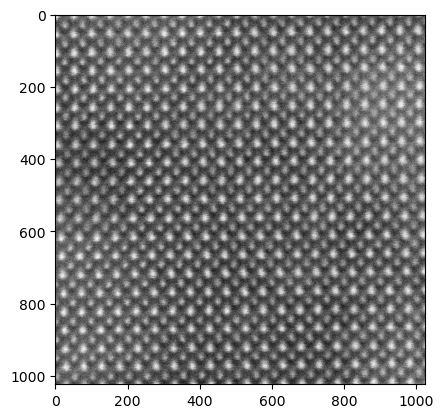

C:\Users\shiki\AppData\Local\Temp\ipykernel_28860\2962801660.py:8: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img_small = img_small.resize((int(scale_0),int(scale_0)),Image.BILINEAR)
C:\Users\shiki\AppData\Local\Temp\ipykernel_28860\2962801660.py:17: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img_large = img_large.resize((int(scale_0),int(scale_0)),Image.BILINEAR)
C:\Users\shiki\AppData\Local\Temp\ipykernel_28860\2962801660.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for m

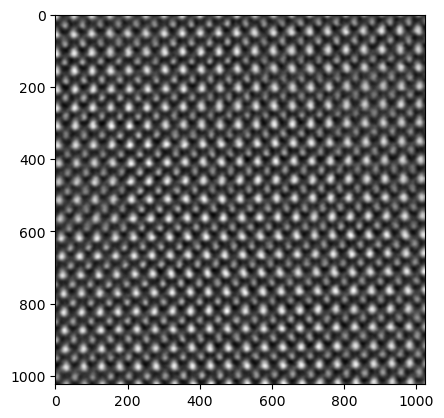

In [7]:
#test
img_path = '022.jpg'
image = Image.open(img_path)
image = image.convert('L')

plt.imshow(image,cmap='gray')
plt.show()

#ImageFilter.MedianFilter(size=3)
#ImageFilter.GaussianBlur(radius=3)
#ImageFilter.FIND_EDGES
#ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3)

result_image = remove_back(image,32)
#将图片存储
result_image.save("image_re_noise.jpg")

plt.imshow(result_image,cmap='gray')
plt.show()

In [8]:
from skimage import data
from skimage.transform import resize
#image00 = data.camera()
#resize(image00,(100, 100)).shape

In [9]:
def pred(image,box_size,periodicity):
    #image = cv2.imread(img_path,0)
    #image = Image.open(img_path)

    #image = image.convert('L')
    #备份原图
    old_image = image

    transform1 = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                               torchvision.transforms.ToTensor()])
    transform2 = torchvision.transforms.ToPILImage()

    output = Image.new('L',(256*periodicity,256*periodicity))
    for i in range(periodicity):
        for j in range(periodicity):
            box_ij = (box_size*i,box_size*j,box_size*(i+1),box_size*(j+1))
            image_ij = image.crop(box_ij)
#     box = (0,0,64,64)
#     image = image.crop(box)
            image_ij,nw,nh = pad_img(image_ij,(256,256))

            #备份原图
            old_image_ij = image_ij
            box = (int((256-nw)//2),int((256-nh)//2),int(256-(256-nw)//2),int(256-(256-nh)//2))
            old_image_ij = old_image_ij.crop(box)

            image_ij = transform1(image_ij)

        #     image = transform1(image).numpy()

        #     #扣背底
        #     image_back1 = small(image,256,32)
        #     image_back = large(image_back1,32,256)
        #     image = image - image_back

        #写入日志，可以在pycharm通过tensorboard --logdir=logs --port=6007查看
        #     writer = SummaryWriter("logs")
        #     writer.add_image("origin_img",image)

            image_ij = torch.reshape(image_ij,(1,1,256,256))

            model = Unet()
            save_path = 'model.pth'
            model.load_state_dict(torch.load(save_path)['model_state_dict'])
            model.eval()
            #使用model.eval()来固定dropout和归一化层，否则每次推理会生成不同的结果
            with torch.no_grad():
                output_ij = model(image_ij)
            #把输出图片也写入日志
            #writer.add_image("predict_img",output.reshape(1,256,256))
#           writer.close()
            #print(output_ij.size())
            output_ij = torch.argmax(output_ij,dim=1)
            #print(output.size())
            output_ij = torch.reshape(output_ij,(256,256))
            aveput_ij = np.average(output_ij)
            max_output_ij = output_ij.max()
            output_ij = output_ij/max_output_ij
            #print(output[70:80,70:80])
            output_ij = output_ij.float()
            output_ij = transform2(output_ij)

            #把灰条部分截取
            output_ij = output_ij.crop(box)
            #print(box_ij,output,output_ij)
            output.paste(output_ij,box = (256*i,256*j,256*(i+1),256*(j+1)))

    return old_image,output

In [10]:
def remove_noise(image,noise_scale=0.5):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    area_sum = []
    for con in contours:
        area = cv2.contourArea(con)
        area_sum.append(area)
    max_area = max(area_sum)
    mean_area = np.mean(area_sum)

C:\Users\shiki\AppData\Local\Temp\ipykernel_28860\197064238.py:3: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  result_image = result_image.resize((512,512),resample = Image.NEAREST)
C:\Users\shiki\AppData\Local\Temp\ipykernel_28860\89815211.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image = image.resize((nw,nh),Image.BICUBIC)


<PIL.Image.Image image mode=L size=1024x1024 at 0x25D2A04DA50>


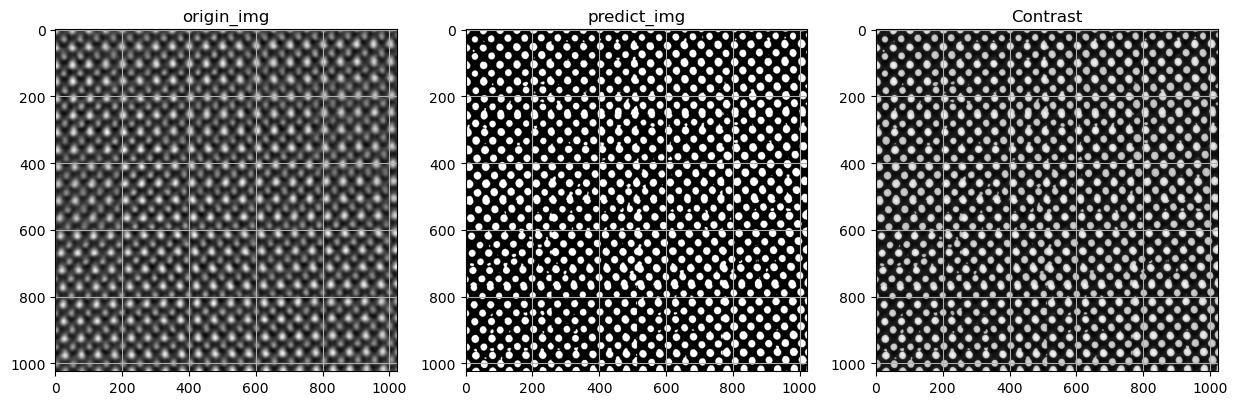

In [11]:
#img_path = 'test2.jpg'
#img_path = '00008.png'
result_image = result_image.resize((512,512),resample = Image.NEAREST)
#result_image = result_image.resize(512,512, Image.NEAREST)
#这边输入需要是图片的尺寸，输出为256X周期
old_image,output = pred(result_image,128,4)
#将两张图片混合
old_image = old_image.resize(output.size)
image = Image.blend(old_image,output,0.5)
print(old_image)

plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
#plt.imshow(old_image,cmap='gray')
plt.imshow(old_image,cmap='gray')
plt.title("origin_img")
plt.grid(alpha=1)
plt.subplot(1,3,2)
plt.imshow(output,cmap='gray')
output.save("image_predict.jpg")
plt.title("predict_img")
plt.grid(alpha=1)
plt.subplot(1,3,3)
plt.imshow(image,cmap='gray')
plt.title("Contrast")
plt.grid(alpha=1)

In [12]:
trans_totensor = torchvision.transforms.ToTensor()
output = output.convert("L")
output = trans_totensor(output).permute(1,2,0).numpy()
output = output.astype("uint8")
print(output.dtype)

uint8


In [13]:
#找中心、半径
#求方差
#对该半径内所有像素求灰度直方图，找峰位

In [14]:
#中心寻找法1 只用来寻找质心，用来测试数据集结果
def find_center_1(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cen_x = []
    cen_y = []
    area_sum = []
    r_sum = []
    for con in contours:
        area = cv2.contourArea(con)
        if area > 5:
            M = cv2.moments(con)
            cx = int(M["m10"]/M["m00"])
            cy = int(M["m01"]/M["m00"])   #求质心
            cen_x.append(cx)
            cen_y.append(cy)
            area_sum.append(area)
            r_i = pow(area/np.pi , 0.5)
            r_sum.append(r_i)
    return cen_x,cen_y,r_sum

In [15]:
#中心寻找法1，对上面部分的完善，用于实际识别

def find_center(image,erode_core = (4,4),area_thre = 0.5):
    #先腐蚀，去除一些噪点
    kernel = np.ones(erode_core, np.uint8)
    output_erode = cv2.erode(image, kernel, iterations = 1)  #腐蚀
    output_none1 = np.ones(output_erode.shape)
    output_none2 = np.ones(output_erode.shape)
    contours, hierarchy = cv2.findContours(output_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(contours)
    cen_x = []
    cen_y = []
    area_sum = []
    r_sum = []
    #记录所有的面积
    for con in contours:
        area = cv2.contourArea(con)
        area_sum.append(area)

    mean_area = np.mean(area_sum)
    max_area = max(area_sum)

    #重置
    area_sum = []
    for con in contours:
        area = cv2.contourArea(con)
        #设置一个面积阈值，在此之下的不予考虑，进一步去除噪点
        if area > area_thre * mean_area:
            M = cv2.moments(con)
            output_cont = cv2.drawContours(output_none1,con,-1,[0,128,128],1)
            cx = int(M["m10"]/M["m00"])
            cy = int(M["m01"]/M["m00"])   #求质心
            cen_x.append(cx)
            cen_y.append(cy)
            area_sum.append(area)
            r_i = pow(area/np.pi , 0.5)
            r_sum.append(r_i)
            output_cen = cv2.circle(output_none2,(cx,cy),2,[0,0,0],2)
    return output_erode,output_cont,output_cen,cen_x,cen_y,area_sum

True

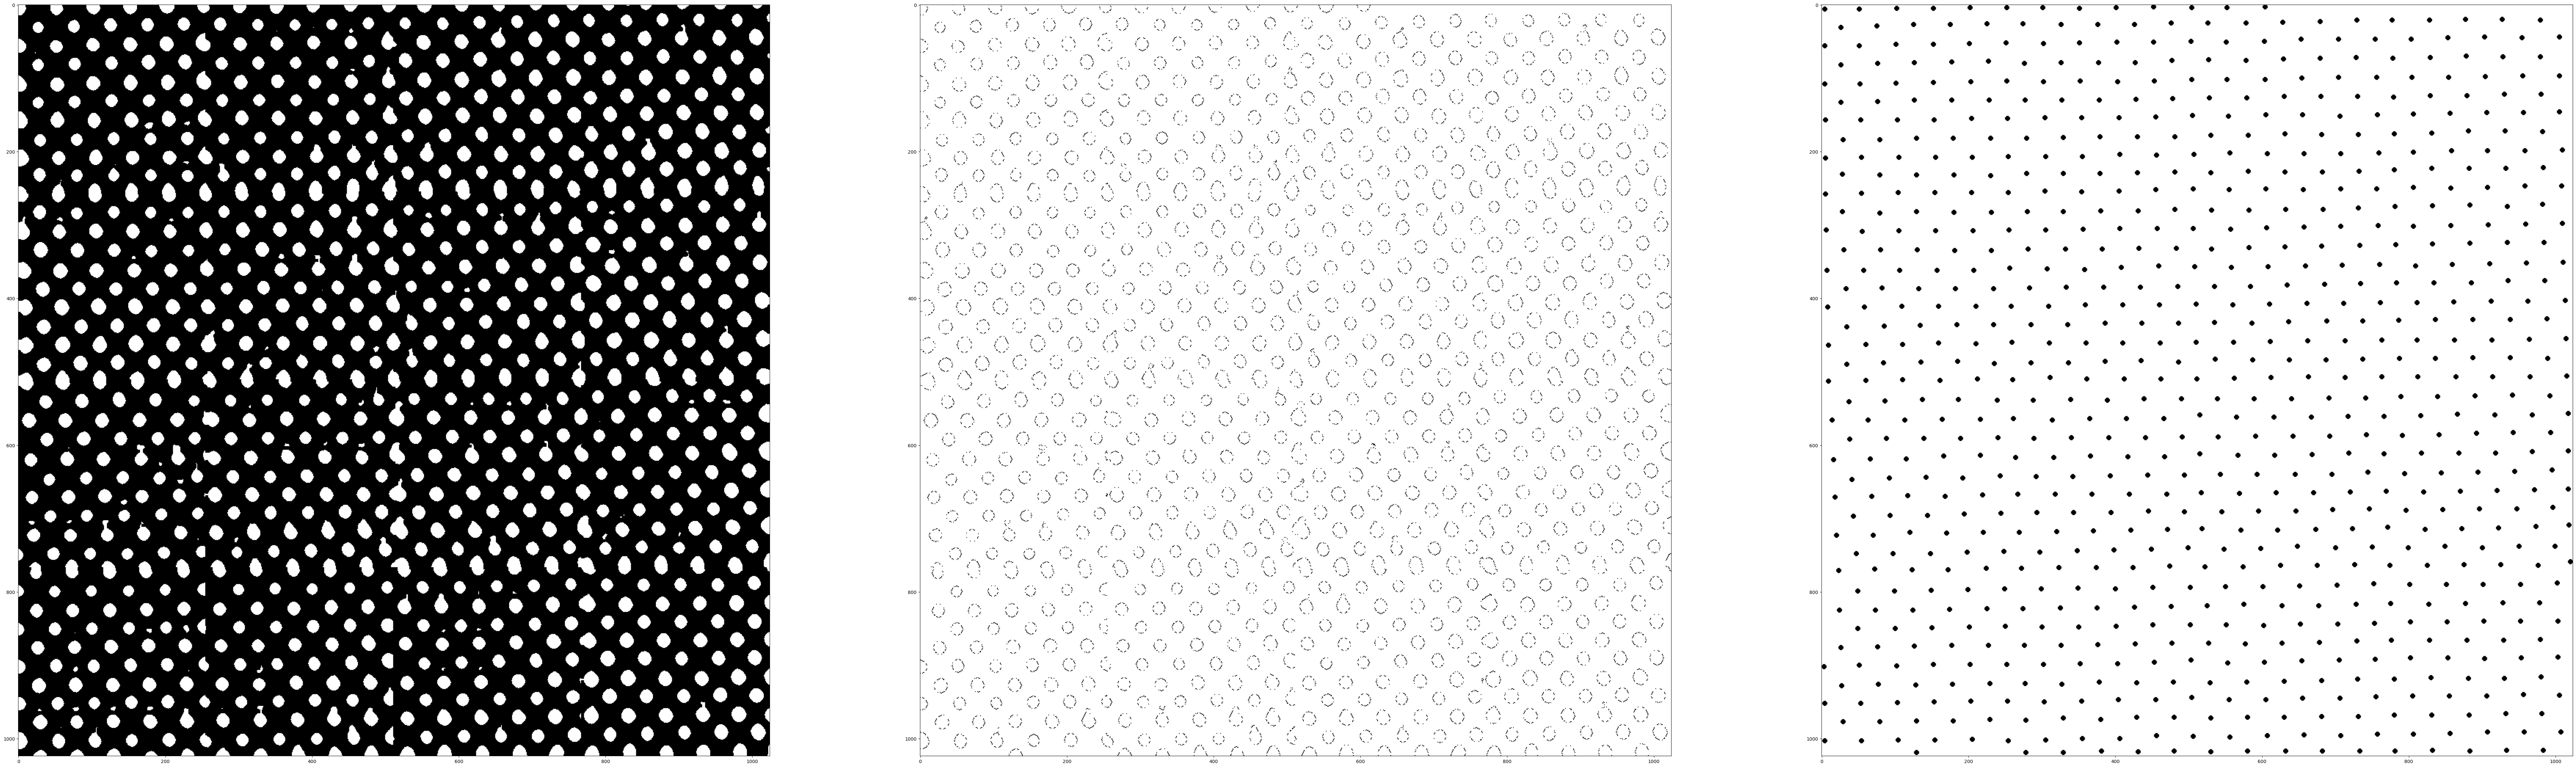

In [16]:
output_erode,output_cont,output_cen,cen_x,cen_y,area_sum = find_center(output)

plt.figure(figsize=(100,50))
plt.subplot(1,3,1)
plt.imshow(output_erode,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(output_cont,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(output_cen,cmap='gray')
cv2.imwrite("image_center.png", output_cen*255)

8.716818095169039 11.901592303208293


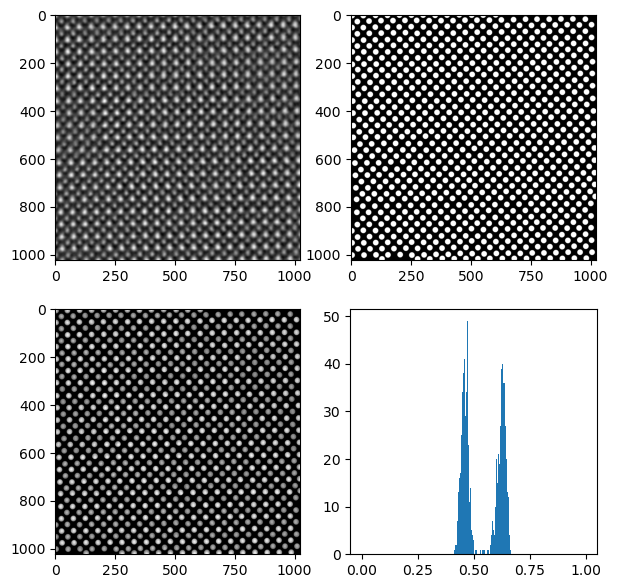

In [18]:
area_max = max(area_sum)
r_max = pow(area_max/np.pi , 0.5)
area_ave = np.average(area_sum)
r_ave = pow(area_ave/np.pi , 0.5)
print(r_ave,r_max)

#old_image = old_image.convert("L")
old_image_1 = trans_totensor(old_image).reshape(old_image.size).numpy()
#old_image_1 = old_image_1.reshape(256,256).numpy()

old_none = np.ones(old_image_1.shape)
old_none_copy = np.ones(old_image_1.shape)
atom_i = []    #记录平均强度
atom_1 = []
atom_2 = []

#mask转化为布尔数组,用来移除原图的背景信息
def remove_background(old_image,mask_img):
    mask_boolean = mask_img[:,:] ==0
    img_removed_background = old_image*mask_boolean
    return mask_boolean,img_removed_background

for i in range(len(cen_x)):
    cx = cen_x[i]
    cy = cen_y[i]

    mask_img = cv2.circle(old_none,(cx,cy),int(r_max+1),[0,0,0],-1)
    #对每一个点分别进行mask，然后计算其强度
    mask_img_i = cv2.circle(old_none_copy,(cx,cy),int(r_max+1),[0,0,0],-1)
    mask_i,old_img_reback_i = remove_background(old_image_1,mask_img_i)
    old_img_reback_i = old_img_reback_i.ravel()
    old_img_reback_i = old_img_reback_i[old_img_reback_i!=0]    #去0
    #print(old_img_reback_i)
    mean_atom_i = old_img_reback_i.mean()
    #记录了每个点的强度信息
    atom_i.append(mean_atom_i)
    #这里的0.5是根据强度分布直方图选择的
    if mean_atom_i>0.5:
        atom_1.append(i)
    elif mean_atom_i<0.5:
        atom_2.append(i)

    old_none_copy = np.ones(old_image_1.shape)    #每次都进行重置

plt.figure(figsize=(7,7))
plt.subplot(2,2,1)
plt.imshow(old_image_1,cmap='gray')

mask,old_img_reback = remove_background(old_image_1,mask_img)

plt.subplot(2,2,2)
plt.imshow(mask,cmap='gray')
plt.subplot(2,2,3)
plt.imshow(old_img_reback,cmap='gray')
plt.subplot(2,2,4)
#n,bins,patch = plt.hist(old_img_reback.ravel(),256,(0.1,1))
n,bins,patch = plt.hist(atom_i,256,(0,1))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

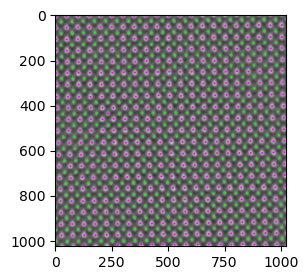

In [46]:
#元素分类
old_image_copy = trans_totensor(old_image).reshape(old_image.size).numpy()
old_image_copy = cv2.cvtColor(old_image_copy, cv2.COLOR_GRAY2BGR)
old_image_copy_1 = old_image_copy
for i in atom_1:
    cx = cen_x[i]
    cy = cen_y[i]
    atom = cv2.circle(old_image_copy,(cx,cy),2,(250,0,250),5)

for i in atom_2:
    cx = cen_x[i]
    cy = cen_y[i]
    atom = cv2.circle(old_image_copy,(cx,cy),2,(0,238,0),5)

plt.figure(figsize=(3,3))
#plt.imshow(atom[0:512,0:512])
plt.imshow(atom)
cv2.imwrite("atom-1.png",atom*256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

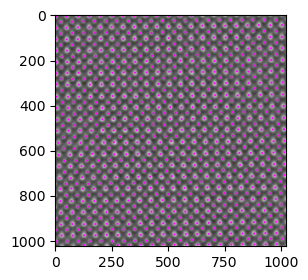

In [45]:
#未分类的也标注一下并且输出保存
old_image_copy = trans_totensor(old_image).reshape(old_image.size).numpy()
old_image_copy = cv2.cvtColor(old_image_copy, cv2.COLOR_GRAY2BGR)
old_image_copy_1 = old_image_copy


for i in range(len(cen_x)):
    cx = cen_x[i]
    cy = cen_y[i]
    #atom_none是未分类的
    atom_none = cv2.circle(old_image_copy_1,(cx,cy),2,(250,0,250),5)

plt.figure(figsize=(3,3))
plt.imshow(atom_none)
cv2.imwrite("atom_none.png",atom_none*256)